## Cryptocurrencies

### Data Scraping

In [1]:
import pandas as pd
import numpy as np

def CryptoData(symbol, frequency):
    #Params: String symbol, int frequency = 300,900,1800,7200,14400,86400
    #Returns: df from first available date
    url ='https://poloniex.com/public?command=returnChartData&currencyPair='+symbol+'&end=9999999999&period='+str(frequency)+'&start=0'
    df = pd.read_json(url)
    df.set_index('date',inplace=True)
    return df

tickers = ['BTC', 'ETC', 'XRP', 'ETH', 'XMR', 'LTC', 'STR', 'BCH', 'NXT', 'ZEC', 'DASH', 'REP']
tickers = ['USDT_' + ticker for ticker in tickers]

prices_df = pd.DataFrame()

In [2]:
for ticker in tickers:
    prices_df = prices_df.join(CryptoData(ticker, 300)['close'].rename(ticker), how='outer')

### Density Estimation

In [3]:
# Percentage change
#daily_returns = historical_prices_panel.pct_change(1)

# Log difference
five_min_returns = np.log(prices_df)
five_min_returns = five_min_returns-five_min_returns.shift(1)

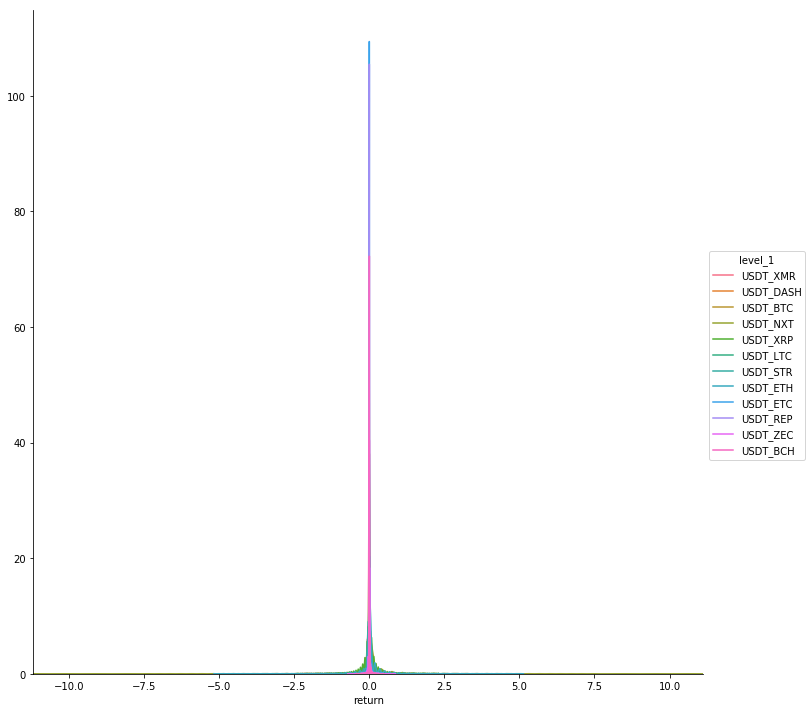

In [4]:
import seaborn as sns
density_df = pd.DataFrame(five_min_returns.stack(), columns=['return']).reset_index()

%matplotlib inline

kde_plot = (sns.FacetGrid(density_df,
                     hue='level_1',
                     size=10,
                     xlim=(min(density_df['return']), max(density_df['return']))).map(sns.kdeplot, 'return', shade=True).add_legend())

### Timeseries Plot

USDT_BTC
1.44% of observations are greater than 3 standard deviations from the mean
0.76% of observations are greater than 4 standard deviations from the mean
The maximum deviation is 192.17 deviations from the mean


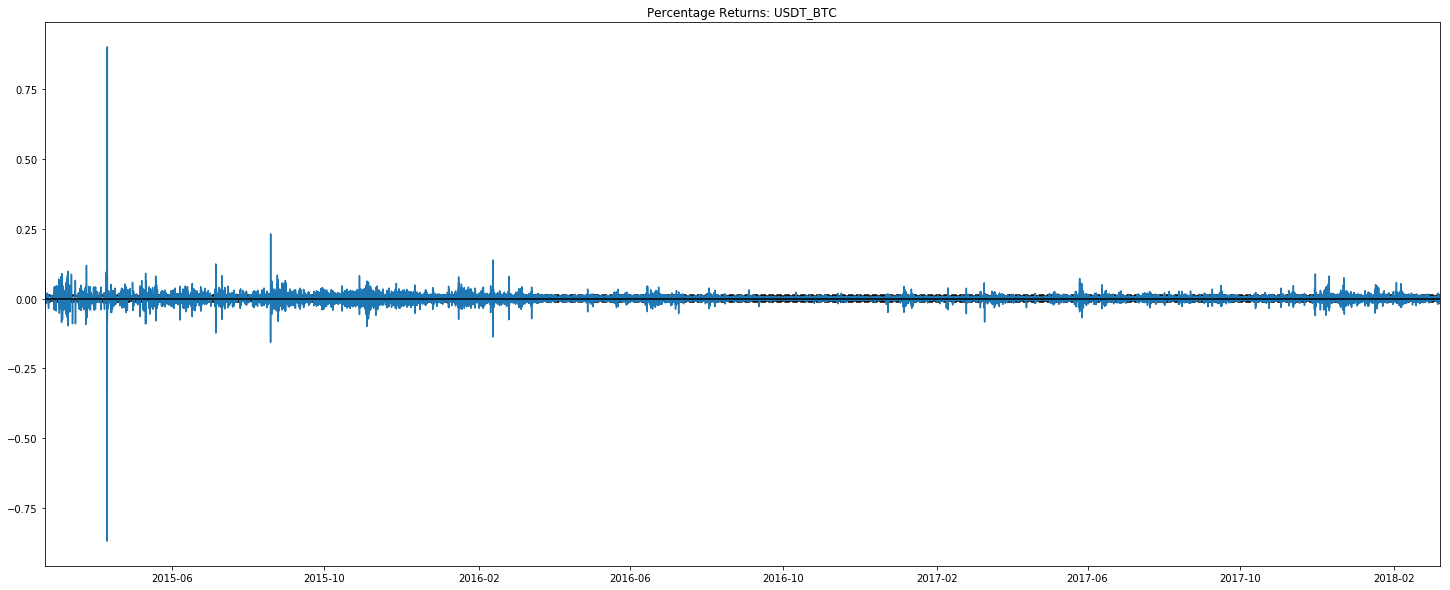

USDT_ETC
1.63% of observations are greater than 3 standard deviations from the mean
0.7% of observations are greater than 4 standard deviations from the mean
The maximum deviation is 67.19 deviations from the mean


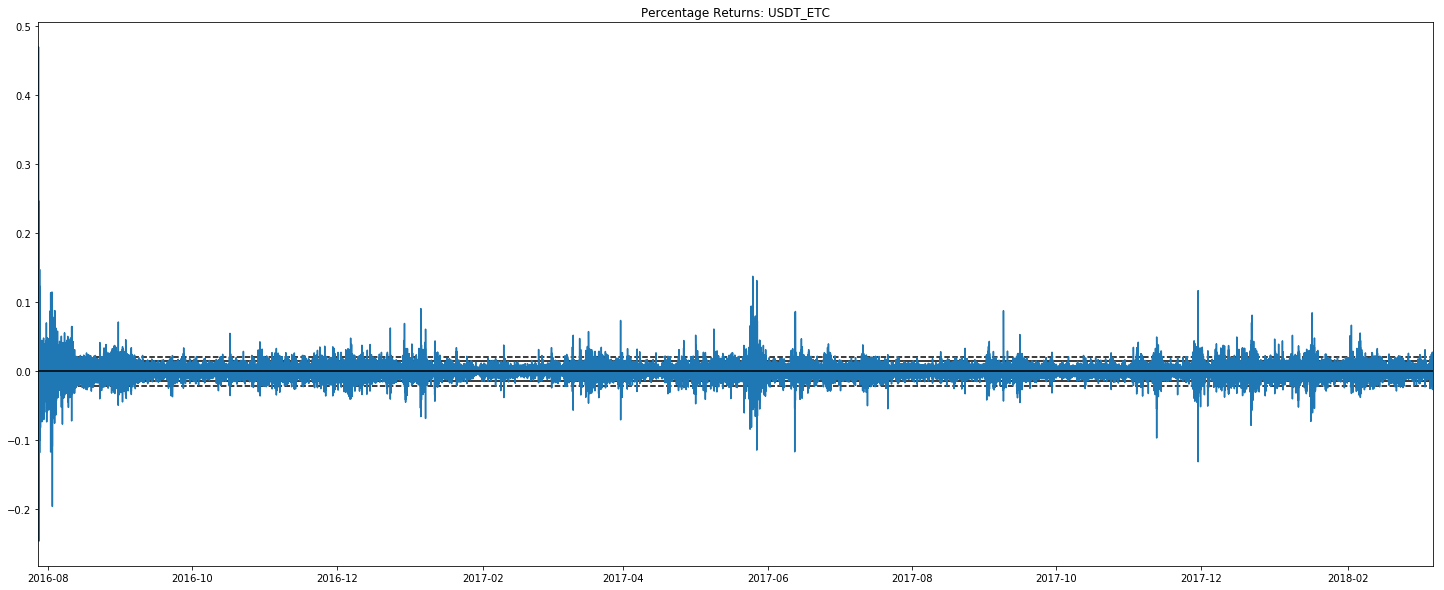

USDT_XRP
0.41% of observations are greater than 3 standard deviations from the mean
0.22% of observations are greater than 4 standard deviations from the mean
The maximum deviation is 166.83 deviations from the mean


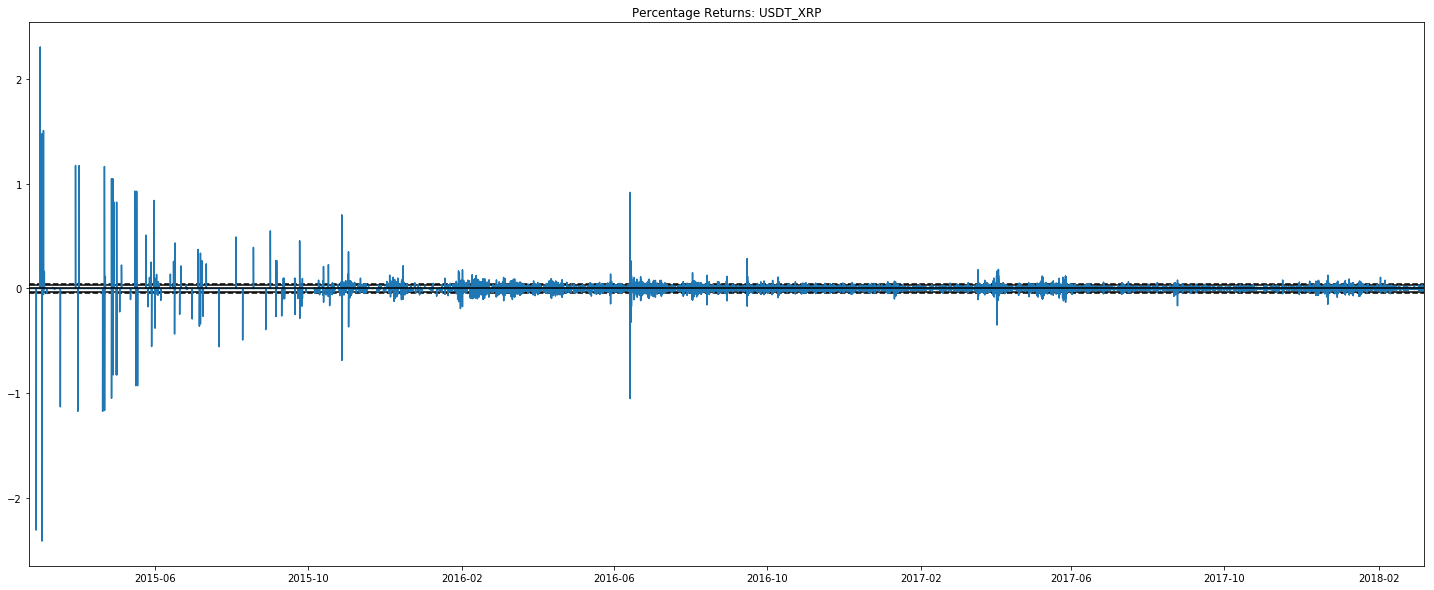

USDT_ETH
0.31% of observations are greater than 3 standard deviations from the mean
0.17% of observations are greater than 4 standard deviations from the mean
The maximum deviation is 312.99 deviations from the mean


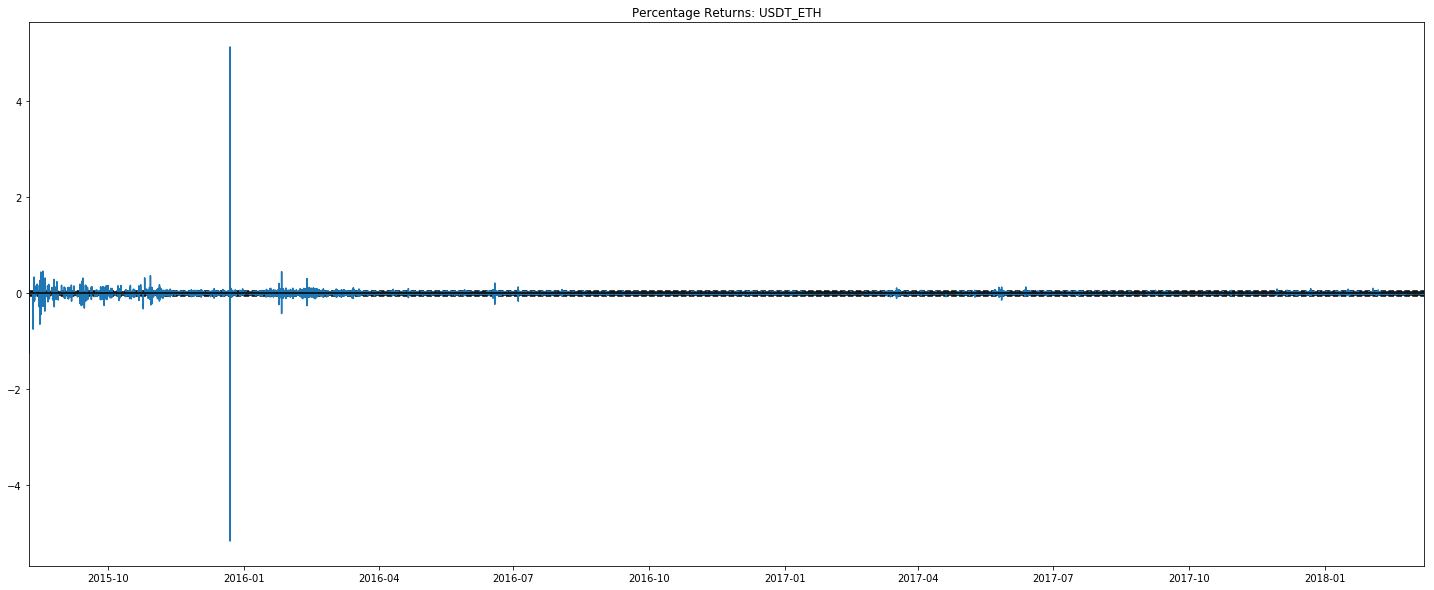

USDT_XMR
0.4% of observations are greater than 3 standard deviations from the mean
0.29% of observations are greater than 4 standard deviations from the mean
The maximum deviation is 125.88 deviations from the mean


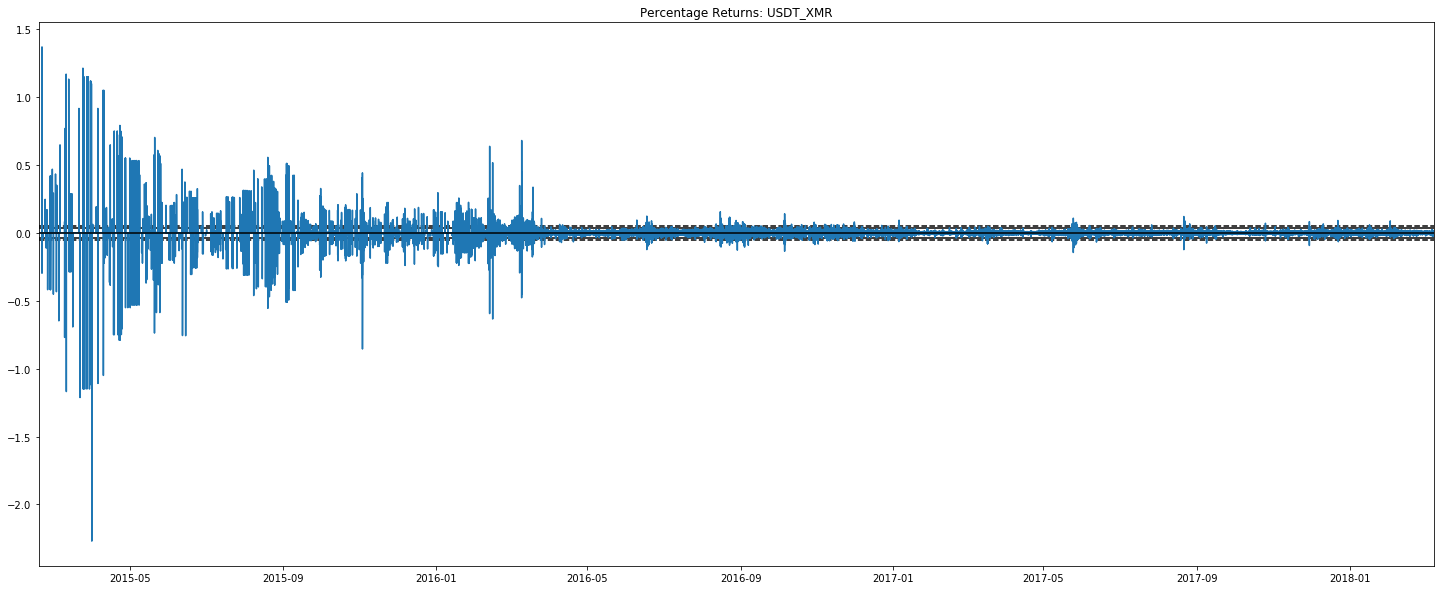

USDT_LTC
0.26% of observations are greater than 3 standard deviations from the mean
0.13% of observations are greater than 4 standard deviations from the mean
The maximum deviation is 239.96 deviations from the mean


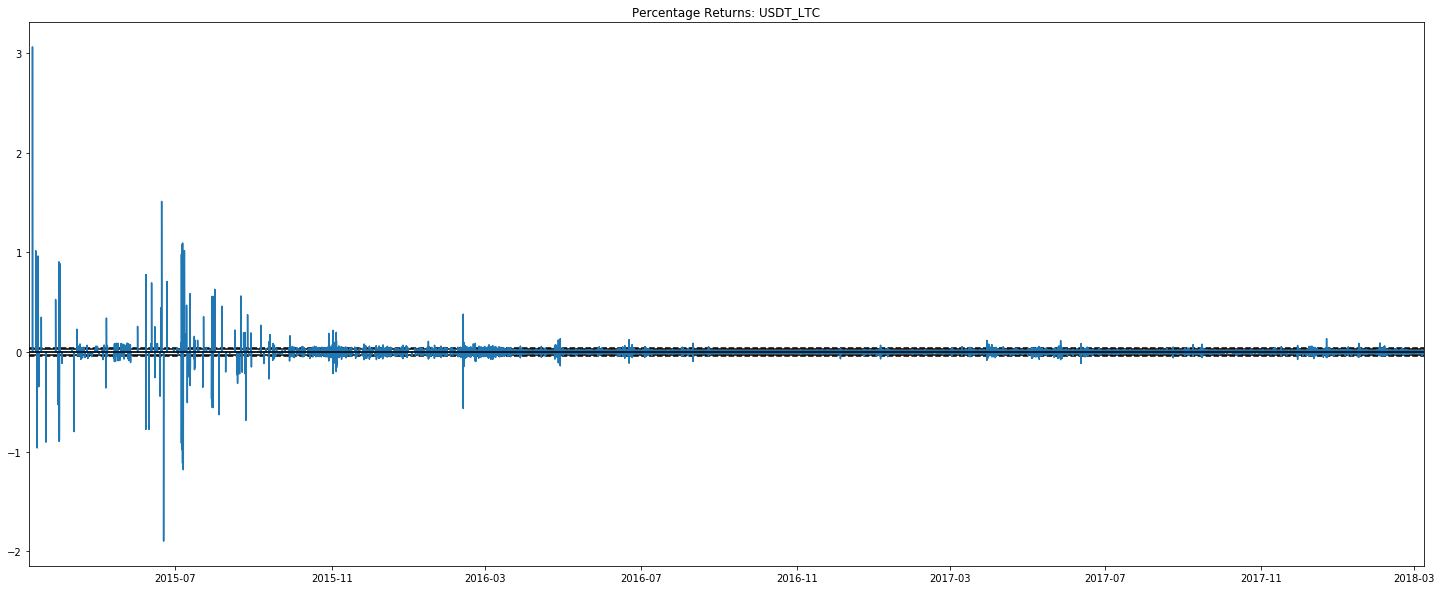

USDT_STR
0.11% of observations are greater than 3 standard deviations from the mean
0.06% of observations are greater than 4 standard deviations from the mean
The maximum deviation is 146.82 deviations from the mean


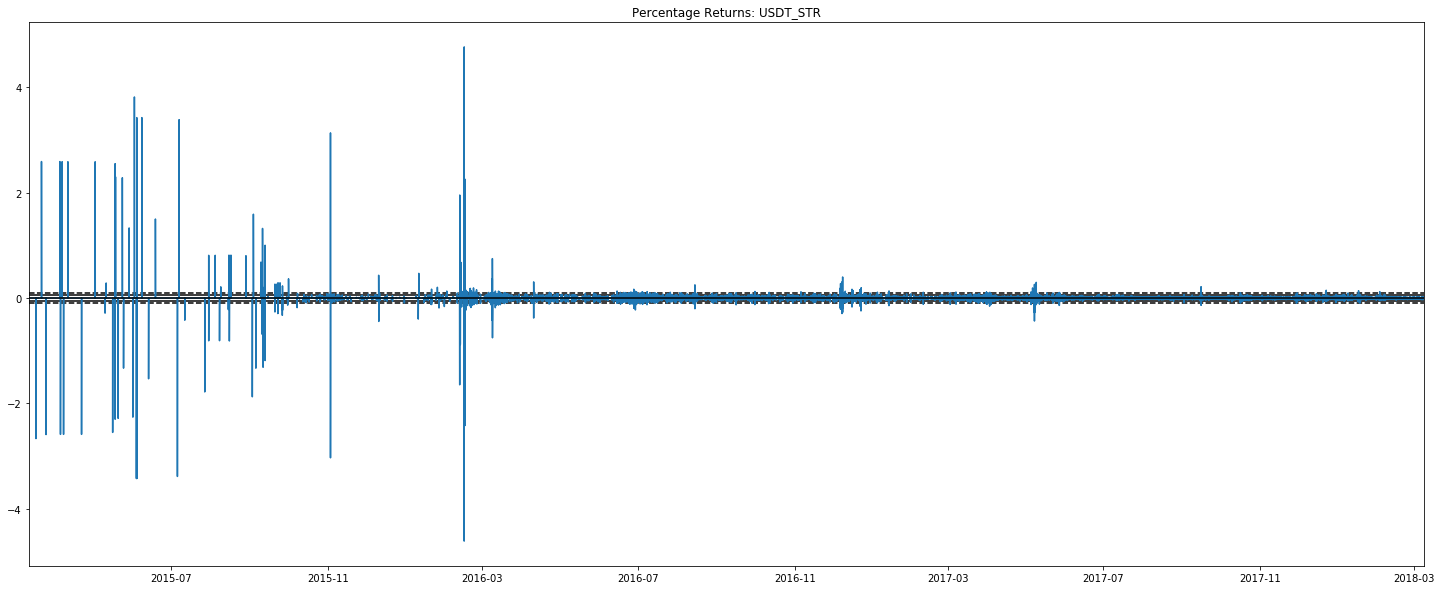

USDT_BCH
1.43% of observations are greater than 3 standard deviations from the mean
0.63% of observations are greater than 4 standard deviations from the mean
The maximum deviation is 58.14 deviations from the mean


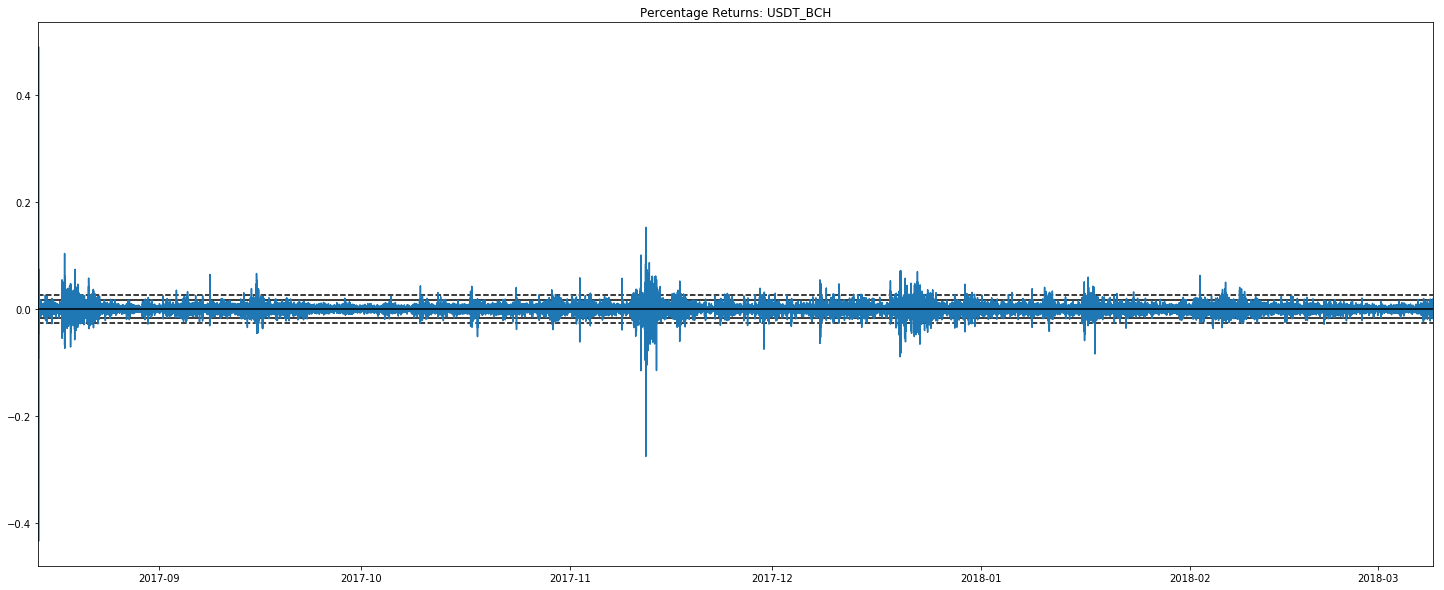

USDT_NXT
0.16% of observations are greater than 3 standard deviations from the mean
0.09% of observations are greater than 4 standard deviations from the mean
The maximum deviation is 369.53 deviations from the mean


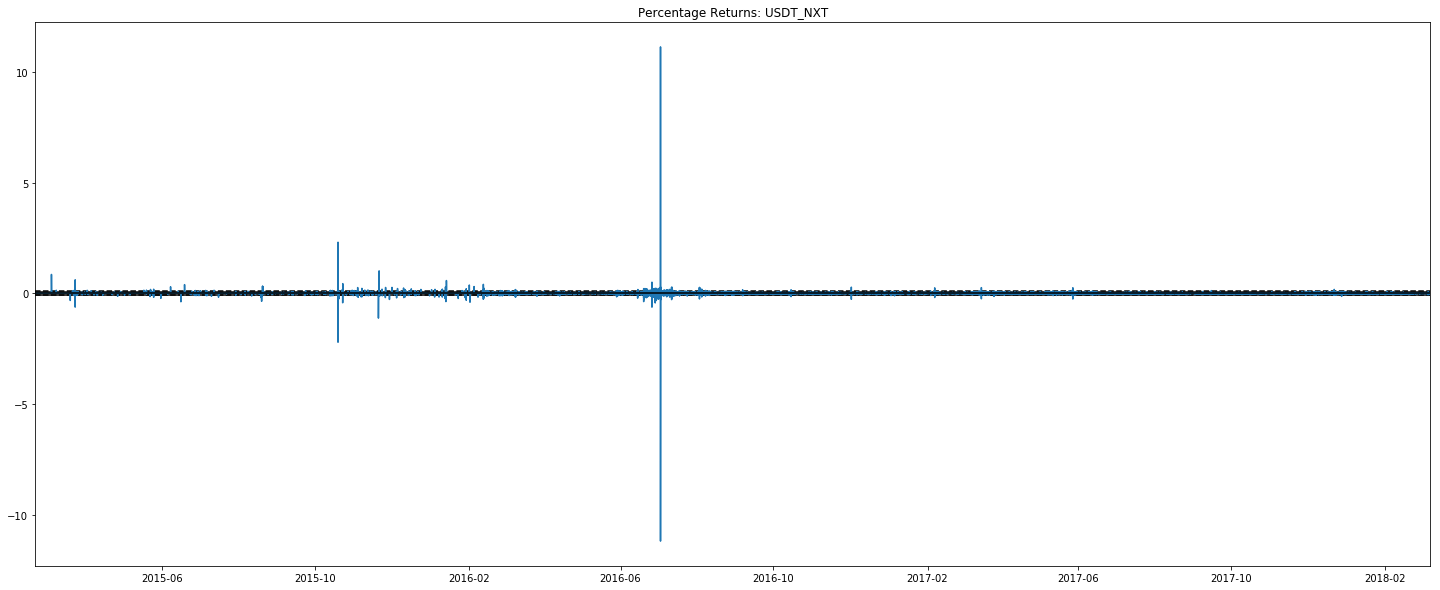

USDT_ZEC
0.96% of observations are greater than 3 standard deviations from the mean
0.5% of observations are greater than 4 standard deviations from the mean
The maximum deviation is 73.75 deviations from the mean


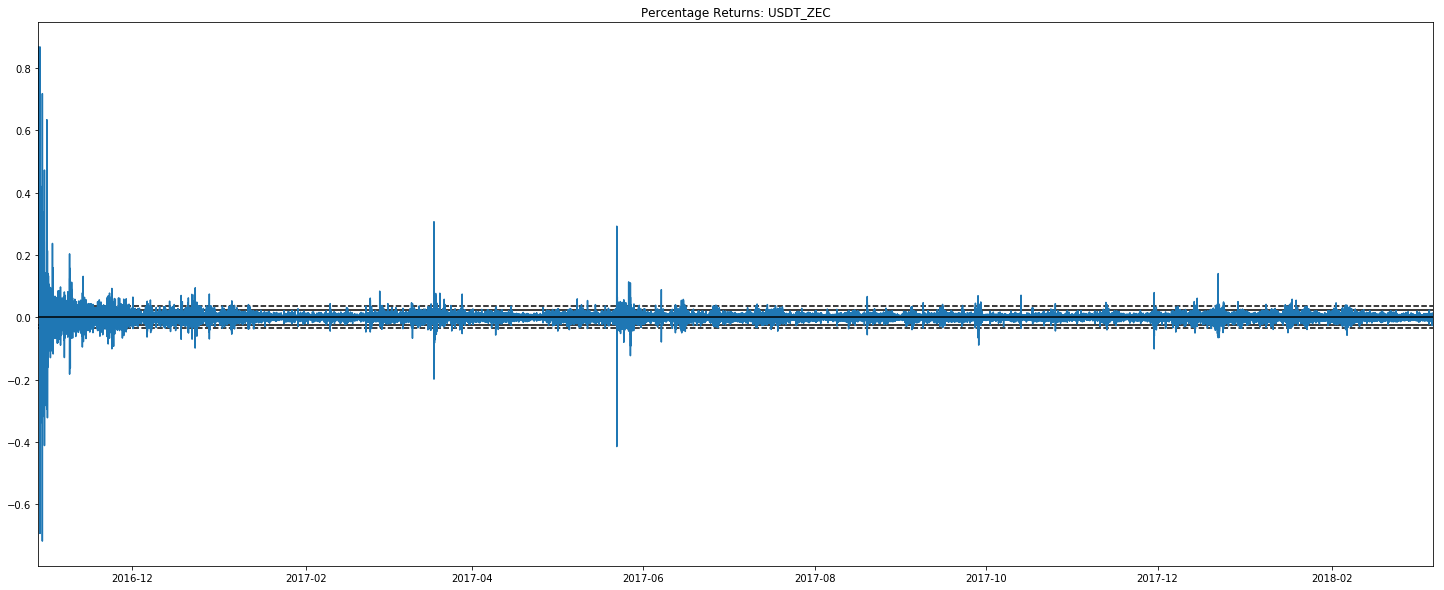

USDT_DASH
0.11% of observations are greater than 3 standard deviations from the mean
0.08% of observations are greater than 4 standard deviations from the mean
The maximum deviation is 206.47 deviations from the mean


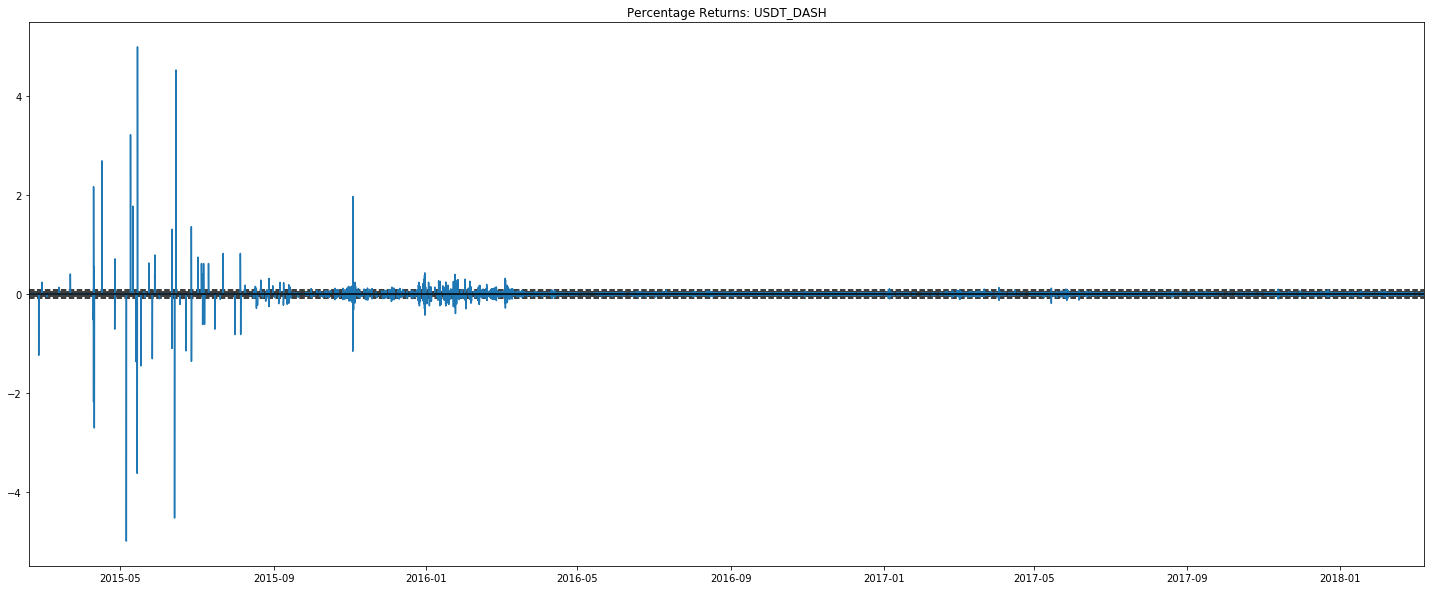

USDT_REP
1.83% of observations are greater than 3 standard deviations from the mean
0.81% of observations are greater than 4 standard deviations from the mean
The maximum deviation is 35.71 deviations from the mean


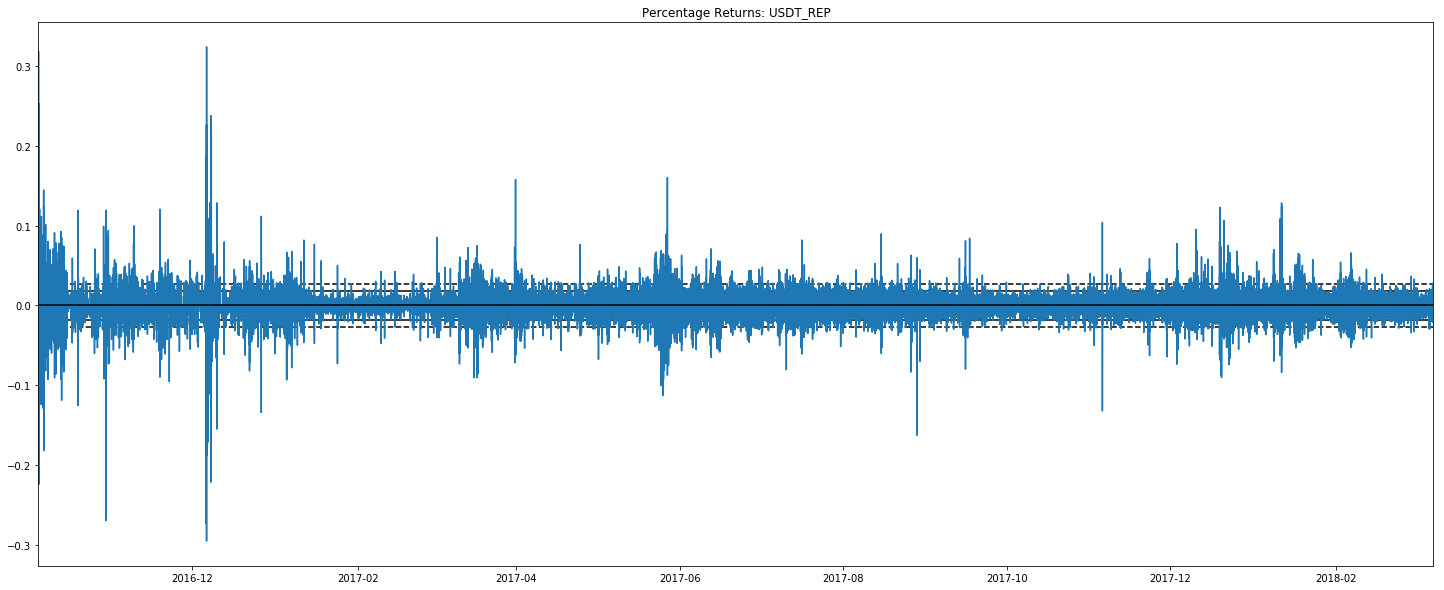

In [5]:
import matplotlib.pyplot as plt

def find_fattails(data, name):
    series = data[data.notnull()]                   # Remove null entries from series
    std = series.std()                            # Find standard deviation
    mean = series.mean()                          # Find mean
    
    print(name)
    for n in (3, 4):
        outliers = series[(series > mean + std * n) | (series < mean - std * n)]
        outliers_pct = len(outliers) / len(series) * 100
        print(str(round(outliers_pct, 2)) + "% of observations are greater than " + str(n) + " standard deviations from the mean")
    
    max_dev = (series.abs().max() - mean)/std
    print("The maximum deviation is " + str(round(max_dev, 2)) + " deviations from the mean")
    
    plt.figure(figsize=(25, 10))
    plt.axhline(mean + std * 2, c='k')
    plt.axhline(mean + std * 3, c='k', ls='--')
    plt.axhline(mean - std * 2, c='k')
    plt.axhline(mean - std * 3, c='k', ls='--')
    plt.plot(series)
    plt.axhline(mean, c='k')
    plt.title('Percentage Returns: ' + name)
    plt.xlim(min(series.index), max(series.index))
    plt.show()
    
for ticker in tickers:
    find_fattails(five_min_returns[ticker], ticker)

### Rank Size Plot

In [6]:
abs_five_min_returns = abs(five_min_returns)

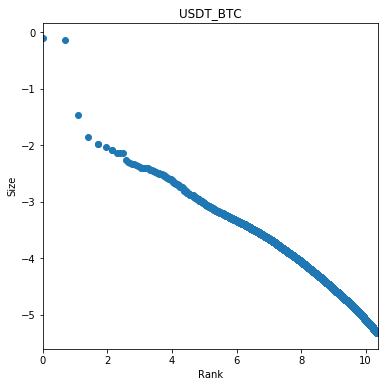

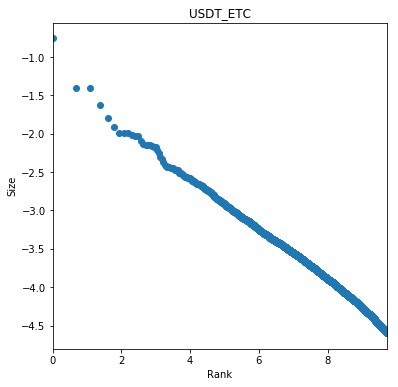

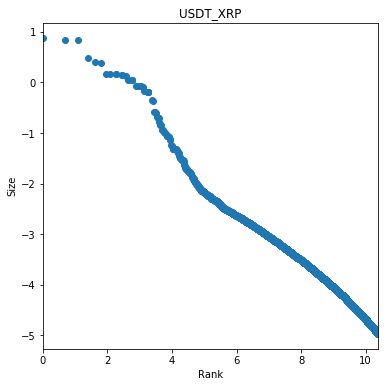

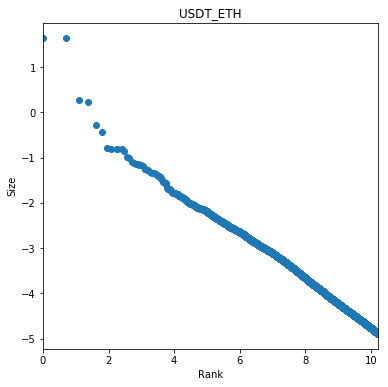

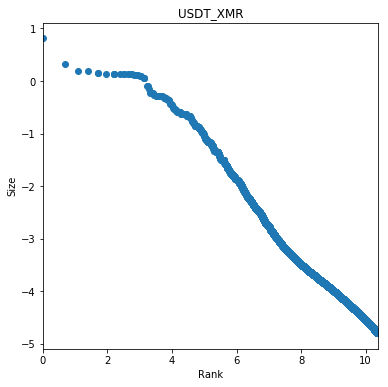

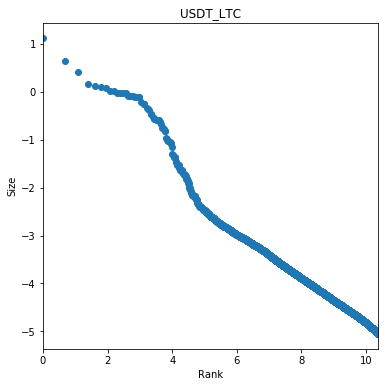

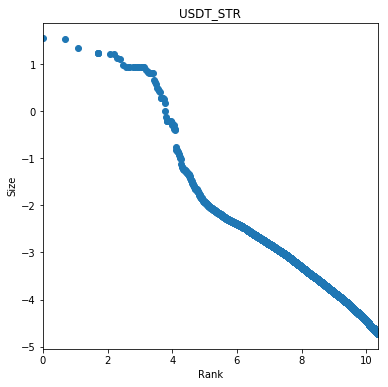

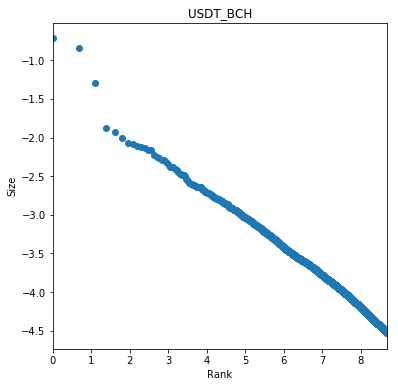

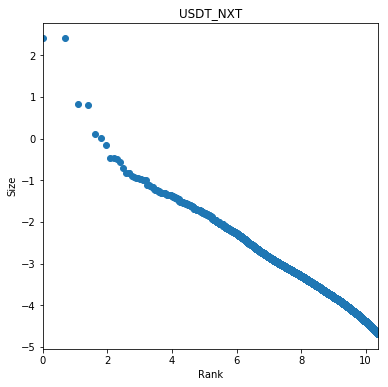

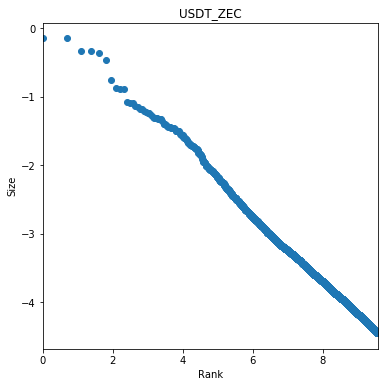

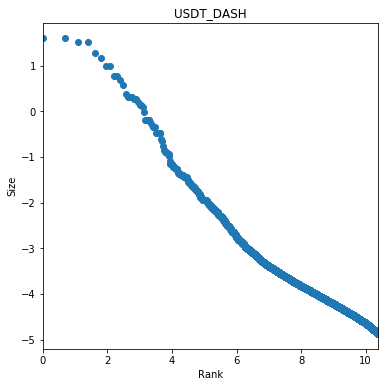

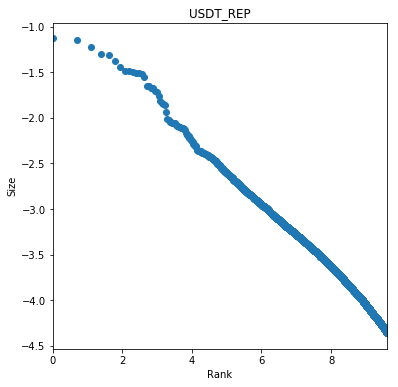

In [7]:
quantile = 0.9

for ticker in tickers: 
    truncation_level = abs_five_min_returns[ticker].quantile(quantile)
    condition = abs_five_min_returns[ticker] > truncation_level
    x = np.log(abs_five_min_returns.rank(ascending=False)[condition][ticker])
    y = np.log(abs_five_min_returns[condition][ticker])
    
    plt.figure(figsize=(6, 6))
    plt.scatter(x, y)
    plt.title(ticker)
    plt.xlabel('Rank')
    plt.ylabel('Size')
    plt.xlim(min(x), max(x))
    plt.show()

### Tail Index Estimation

In [8]:
import statsmodels.api as sm

    
def log_log_rank_size_reg(ticker, quantile, n):
    truncation_level = abs_five_min_returns[ticker].quantile(quantile)
    condition = abs_five_min_returns[ticker] > truncation_level

    Y = np.log(abs_five_min_returns.rank(ascending=False)[condition][ticker] - 1/2)
    X = -np.log(abs_five_min_returns[condition][ticker])
    X = sm.add_constant(X)

    model = sm.OLS(Y,X)
    results = model.fit()

    se = np.sqrt(2/n)*results.params[1]

    output = 'Top ' + str(round(100-quantile*100)) + '%  --  ' +  'Estimated Tail Index: ' + str(round(results.params[1], 2)) + (
    '  --  95% Confidence Interval: [' + str(round(results.params[1]-1.96*se, 2)) + ', ' + str(round(results.params[1]+1.96*se, 2)) + ']')
    
    print(output)

/Users/QBatista/anaconda/envs/tensorflow/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [9]:
for ticker in tickers:
    print(ticker)
    n = abs_five_min_returns[ticker].dropna().shape[0]
    print("total number of observations: " + str(n))
    log_log_rank_size_reg(ticker, 0.9, n)
    log_log_rank_size_reg(ticker, 0.95, n)
    print("")

USDT_BTC
total number of observations: 320656
Top 10%  --  Estimated Tail Index: 2.06  --  95% Confidence Interval: [2.05, 2.07]
Top 5%  --  Estimated Tail Index: 2.3  --  95% Confidence Interval: [2.29, 2.31]

USDT_ETC
total number of observations: 169665
Top 10%  --  Estimated Tail Index: 2.73  --  95% Confidence Interval: [2.71, 2.75]
Top 5%  --  Estimated Tail Index: 2.95  --  95% Confidence Interval: [2.93, 2.97]

USDT_XRP
total number of observations: 320358
Top 10%  --  Estimated Tail Index: 1.74  --  95% Confidence Interval: [1.74, 1.75]
Top 5%  --  Estimated Tail Index: 1.88  --  95% Confidence Interval: [1.87, 1.89]

USDT_ETH
total number of observations: 271851
Top 10%  --  Estimated Tail Index: 1.86  --  95% Confidence Interval: [1.85, 1.87]
Top 5%  --  Estimated Tail Index: 1.88  --  95% Confidence Interval: [1.87, 1.89]

USDT_XMR
total number of observations: 321426
Top 10%  --  Estimated Tail Index: 1.63  --  95% Confidence Interval: [1.62, 1.64]
Top 5%  --  Estimated Ta

## REITs

### Data Scraping

In [10]:
from bs4 import BeautifulSoup
from urllib.request import urlopen

list_public_reits_us_wiki_link = 'https://en.wikipedia.org/wiki/List_of_public_REITs_in_the_United_States'

soup_wiki = BeautifulSoup(urlopen(list_public_reits_us_wiki_link), 'html.parser')
table_wiki = soup_wiki.find("table", {"class": "wikitable sortable"})

header = table_wiki.findAll('th')
if header[2].string != "Ticker Symbol":
    raise Exception("Can't parse wikipedia's table!")
    
tickers = []

rows = table_wiki.findAll('tr')
for row in rows:
    fields = row.findAll('td')
    if fields:
        ticker = fields[2].findAll('a')[1].string
        tickers.append(ticker)

In [11]:
from pandas_datareader.data import DataReader
from datetime import date

start = date(1950, 1, 2)
end = date.today()

data_source = 'google'

prices_df = pd.DataFrame()

In [12]:
# Often fails-- run multiple times until completed
for ticker in tickers:
    try:
        prices_df[ticker]
    except:
        print('Scraping data for ' + ticker)
        try:
            prices_df = \
            prices_df.join(DataReader(ticker, data_source, start=start, end=end, retry_count=5)['Close'].rename(ticker), how='outer')
        except:
            print(ticker + ' failed')
            next

Scraping data for DCT


/Users/QBatista/anaconda/envs/tensorflow/lib/python3.5/site-packages/pandas_datareader/google/daily.py:40: UnstableAPIWarning: 
The Google Finance API has not been stable since late 2017. Requests seem
to fail at random. Failure is especially common when bulk downloading.

  warnings.warn(UNSTABLE_WARNING, UnstableAPIWarning)


Scraping data for MAA
Scraping data for STAG
Scraping data for GPT
Scraping data for PLD
Scraping data for PSB
Scraping data for REXR
Scraping data for TRNO
Scraping data for LPT
Scraping data for MNR
Scraping data for ARE
ARE failed
Scraping data for BXP
Scraping data for BDN
Scraping data for CIO
CIO failed
Scraping data for CXP
Scraping data for OFC
Scraping data for GOV
Scraping data for CLI
CLI failed
Scraping data for PDM
Scraping data for SLG
Scraping data for BRX
Scraping data for CBL
CBL failed
Scraping data for GGP
Scraping data for MAC
Scraping data for PEI
Scraping data for SPG
Scraping data for TCO
TCO failed
Scraping data for WPG
WPG failed
Scraping data for SRG
SRG failed
Scraping data for AKR
Scraping data for CDR
Scraping data for DDR
Scraping data for FRT
Scraping data for KIM
Scraping data for KRG
Scraping data for RPT
Scraping data for REG
REG failed
Scraping data for SKT
Scraping data for WRI
Scraping data for WSR
Scraping data for NNN
Scraping data for O
Scraping 

### Visualization

In [13]:
daily_returns = np.log(prices_df)
daily_returns = daily_returns-daily_returns.shift(1)

In [16]:
abs_daily_returns = abs(daily_returns)

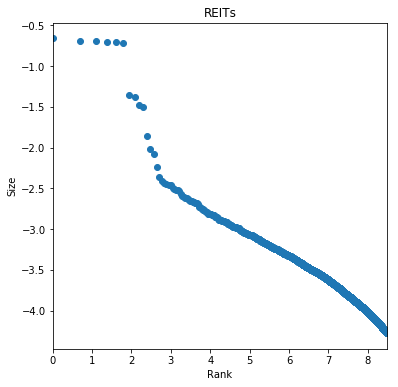

In [18]:
pooled_returns = abs_daily_returns.stack()

quantile = 0.8

truncation_level = pooled_returns.quantile(quantile)
condition = pooled_returns > truncation_level
x = np.log(pooled_returns.rank(ascending=False)[condition])
y = np.log(pooled_returns[condition])

plt.figure(figsize=(6, 6))
plt.scatter(x, y)
plt.title('REITs')
plt.xlabel('Rank')
plt.ylabel('Size')
plt.xlim(min(x), max(x))
plt.show()

### Tail Index Estimation

In [19]:
abs_daily_returns = abs(daily_returns)

In [23]:
quantile = 0.9

n = pooled_returns.dropna().shape[0]
print("total number of observations: " + str(n))

def pooled_log_log_rank_size_reg(quantile):
    truncation_level = pooled_returns.quantile(quantile)
    condition = pooled_returns > truncation_level

    Y = np.log(pooled_returns.rank(ascending=False)[condition] - 1/2)
    X = -np.log(pooled_returns[condition])
    X = sm.add_constant(X)

    model = sm.OLS(Y,X)
    results = model.fit()

    se = np.sqrt(2/n)*results.params[1]

    output = 'Top ' + str(round(100-quantile*100)) + '%  --  ' +  'Estimated Tail Index: ' + str(round(results.params[1], 2)) + (
    '  --  95% Confidence Interval: [' + str(round(results.params[1]-1.96*se, 2)) + ', ' + str(round(results.params[1]+1.96*se, 2)) + ']')

    print(output)
    
pooled_log_log_rank_size_reg(0.9)
pooled_log_log_rank_size_reg(0.95)

total number of observations: 24483
Top 10%  --  Estimated Tail Index: 2.96  --  95% Confidence Interval: [2.91, 3.02]
Top 5%  --  Estimated Tail Index: 2.89  --  95% Confidence Interval: [2.84, 2.94]
